In [45]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

In [47]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train.shape

(60000, 784)

In [48]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 10

input_shape

(784,)

Reparameterization Trick
Reparameterization trick, which makes the network differentiable. Reparameterization trick basically divert the non-differentiable operation out of the network, so that, even though we still involve a thing that is non-differentiable, at least it is out of the network, hence the network could still be trained.
The reparameterization trick is as follows. Recall, if we have $ x \sim N(\mu, \sum)$ and then standardize it so that $ \mu = 0, \sum = 1 $, we could revert it back to the original distribution by reverting the standardization process. Hence, we have this equation:$$
x = \mu + \sum x^.5
$$
With that in mind, we could extend it. If we sample from a standard normal distribution, we could convert it to any Gaussian we want if we know the mean and the variance. Hence we could implement our sampling operation of z by:
$$
x = \mu(X) + \sum (X)^.5 \epsilon
$$
where $
\epsilon \sim  N(0,1)
$
Now, during backpropagation, we don’t care anymore with the sampling process, as it is now outside of the network, i.e. doesn’t depend on anything in the net, hence the gradient won’t flow through it.
Now, during backpropagation, we don’t care anymore with the sampling process, as it is now outside of the network, i.e. doesn’t depend on anything in the net, hence the gradient won’t flow through it.

In [49]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [50]:

inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)


z = Lambda(sampling, name='z')([z_mean, z_log_var])

In [51]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_14[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_14[0][0]                   
____________________________________________________________________________________________

In [52]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               1536      
_________________________________________________________________
dense_16 (Dense)             (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [53]:

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [54]:

models = (encoder, decoder)
data = (x_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss
#reconstruction_loss = mse(inputs, outputs)
reconstruction_loss = binary_crossentropy(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


In [55]:

weight_file = "vae_mlp_mnist.h5"
if os.path.exists(weight_file):
    vae.load_weights(weight_file)
else:
    # train the autoencoder
    vae.fit(x_train,
        epochs=epochs, verbose=1,
        batch_size=batch_size,
        validation_data=(x_test, None))
    vae.save_weights(weight_file)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 80s 1ms/step - loss: 197.4344 - val_loss: 172.1652
Epoch 2/10
60000/60000 [==============================] - 77s 1ms/step - loss: 169.8648 - val_loss: 166.7112
Epoch 3/10
60000/60000 [==============================] - 79s 1ms/step - loss: 165.5349 - val_loss: 163.4598
Epoch 4/10
60000/60000 [==============================] - 78s 1ms/step - loss: 162.9751 - val_loss: 161.7179
Epoch 5/10
60000/60000 [==============================] - 80s 1ms/step - loss: 161.1692 - val_loss: 160.5152
Epoch 6/10
60000/60000 [==============================] - 80s 1ms/step - loss: 159.7245 - val_loss: 159.2245
Epoch 7/10
60000/60000 [==============================] - 74s 1ms/step - loss: 158.5779 - val_loss: 158.3876
Epoch 8/10
60000/60000 [==============================] - 74s 1ms/step - loss: 157.5871 - val_loss: 157.5880
Epoch 9/10
60000/60000 [==============================] - 74s 1ms/step - loss:

In [56]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

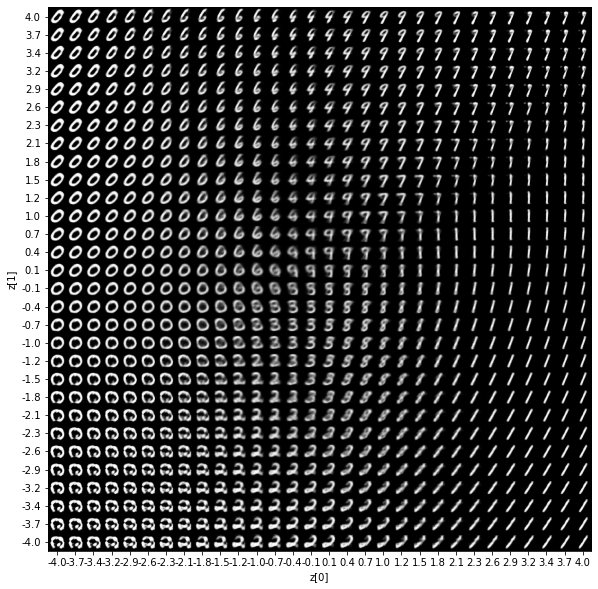

In [57]:
plot_results(models, data, batch_size=batch_size, model_name="vae_mlp")

<Figure size 3600x1440 with 0 Axes>

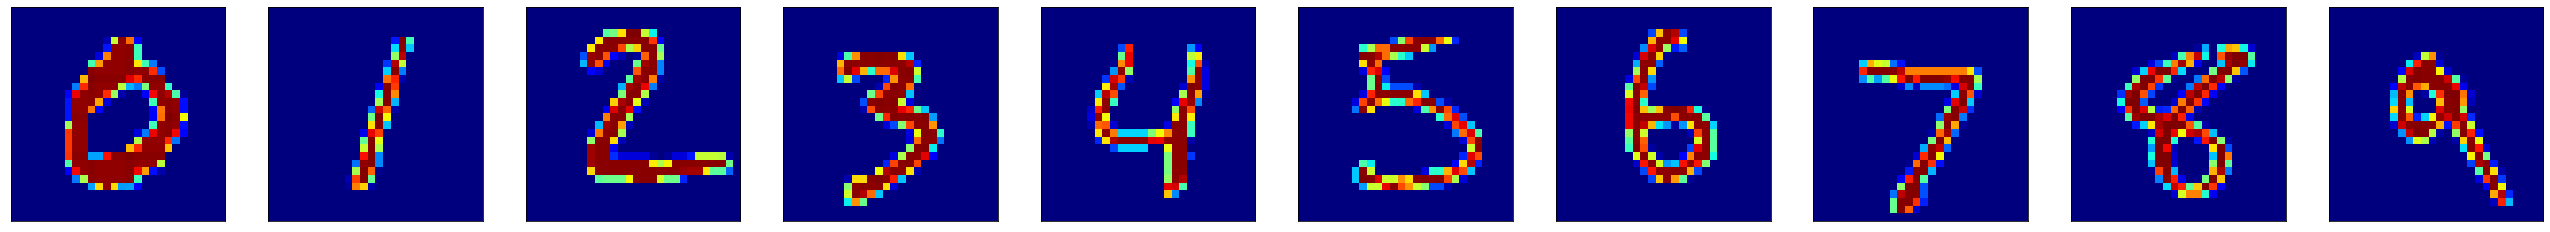

In [58]:
test_image_list = [x_test[3], x_test[2], x_test[1], x_test[30],x_test[4], x_test[15],x_test[21],x_test[0],x_test[84],x_test[7]]
plt.figure(figsize=(50, 20))
x = 100
plt.figure(figsize=(50, 20))
for n, _x in enumerate(test_image_list):
    _x = _x.reshape(image_size, image_size)      
    ax = plt.subplot(len(test_image_list)/10 + 1, 11 , n + 1)
    plt.imshow(_x, cmap=plt.cm.jet)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)     
plt.show()

In [59]:
def linear_interpolation(model, x_from, x_to, steps):
    n = steps + 1

    t_from = encoder.predict(np.array([x_from]))[0]
    t_to = encoder.predict(np.array([x_to]))[0] 

    diff = t_to - t_from
    inter = np.zeros((n, t_from.shape[0], t_from.shape[1]))
    for i in range(n):
        inter[i] = t_from + i / steps * diff
    _inter = np.reshape(inter, [-1, t_from.shape[0] * t_from.shape[1]])
    return decoder.predict(_inter)

def plot_linear_interpolations(x_from, x_to, steps=10):
    x = linear_interpolation(vae, x_from, x_to, steps)
    plt.figure(figsize=(50, 20))
    for n, _x in enumerate(x):
        _x = _x.reshape(image_size, image_size)      
        ax = plt.subplot(len(x)/10 + 1, 11 , n + 1)
        plt.imshow(_x, cmap=plt.cm.jet)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)     
    plt.show()

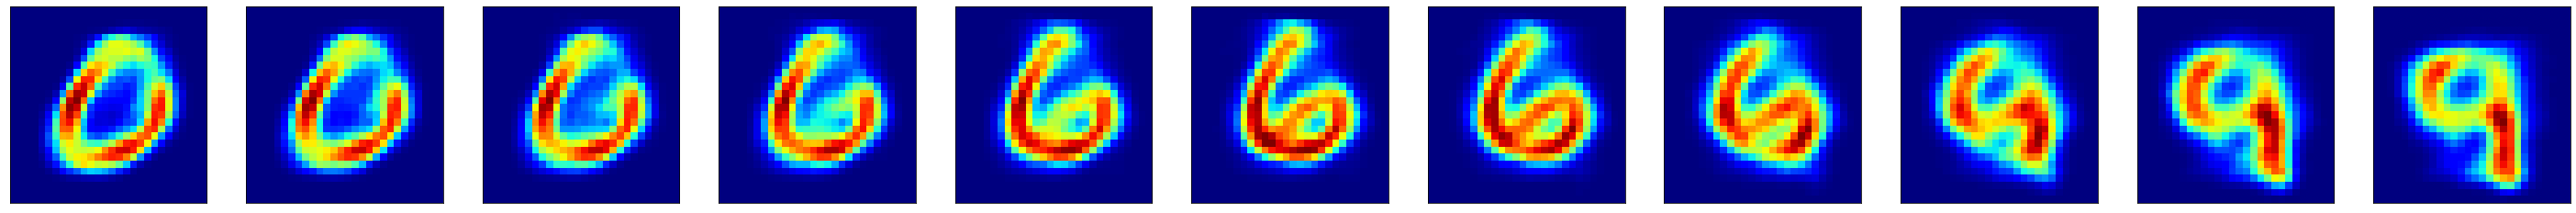

In [60]:
x = 0
y = 9
plot_linear_interpolations(test_image_list[x], test_image_list[y])